In [5]:
import cv2 
from mtcnn.mtcnn import MTCNN
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from keras.callbacks import ModelCheckpoint

In [2]:
uncropped_dir = 'images/uncropped'
train_dir = 'images/training'
valid_dir = 'images/validation'

In [13]:
detector = MTCNN()

In [281]:
def png_to_array(image_path):
    img = Image.open(image_path).convert('RGB')
    return np.asarray(img).astype(np.float32)

In [291]:
paths_adult = os.listdir(uncropped_dir+'/adult')
paths_child = os.listdir(uncropped_dir+'/child')

In [284]:
i = j = 0

for path in paths_adult:
    img = cv2.imread(os.path.join(uncropped_dir+'/adult', path))
    faces = detector.detect_faces(img)
    for face in faces:
        (x, y, w, h) = face['box']
        cropped_face = img[y:y+h, x:x+w]
        cropped_face = cv2.resize(cropped_face, (128,128))
        if np.random.uniform(0,100)<70:
            cv2.imwrite(os.path.join(train_dir+'/0', str(i)+'.jpg'), cropped_face)
            i += 1
        else:
            cv2.imwrite(os.path.join(valid_dir+'/0', str(j)+'.jpg'), cropped_face)
            j += 1

In [292]:
i = j = 0
for path in paths_child:
    img = cv2.imread(os.path.join(uncropped_dir+'/child', path))
    faces = detector.detect_faces(img)
    for face in faces:
        (x, y, w, h) = face['box']
        cropped_face = img[y:y+h, x:x+w]
        cropped_face = cv2.resize(cropped_face, (128,128))
        if np.random.uniform()<0.7:
            cv2.imwrite(os.path.join(train_dir+'/1', str(i)+'.jpg'), cropped_face)
            i += 1
        else:
            cv2.imwrite(os.path.join(valid_dir+'/1', str(j)+'.jpg'), cropped_face)
            j += 1

In [334]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=(1, 1.1),
    fill_mode='nearest'
)

# only rescaling for validation
valid_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    'images/training',  
    target_size=(128, 128), 
    batch_size=batch_size,
    class_mode='binary')  


valid_generator = valid_datagen.flow_from_directory(
        'images/validation',
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='binary')

Found 697 images belonging to 2 classes.
Found 313 images belonging to 2 classes.


In [6]:
xception_layer = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    pooling='max',
)
for layer in xception_layer.layers:
    layer.trainable = True

In [7]:
input_layer = tf.keras.layers.Input(shape=(128, 128, 3))
x = xception_layer(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input_layer, output_layer)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0     

In [8]:
model_version = 5


def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint(f'models/model_v{model_version}.hdf5', monitor='val_acc', save_best_only=True)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc', 'AUC'])

In [342]:
epochs = 50

history = model.fit(
    train_generator,
    steps_per_epoch= 693 // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps= 313 // batch_size,
    callbacks=[checkpoint, lr_scheduler],
    shuffle=True)

Epoch 1/50
43/43 [==============================] - 195s 4s/step - loss: 0.7703 - acc: 0.5756 - auc: 0.6058 - val_loss: 2.4446 - val_acc: 0.5428 - val_auc: 0.6420
Epoch 2/50
43/43 [==============================] - 176s 4s/step - loss: 0.6576 - acc: 0.6579 - auc: 0.7079 - val_loss: 0.6110 - val_acc: 0.6316 - val_auc: 0.7987
Epoch 3/50
43/43 [==============================] - 162s 4s/step - loss: 0.5146 - acc: 0.7548 - auc: 0.8318 - val_loss: 0.5691 - val_acc: 0.7862 - val_auc: 0.8908
Epoch 4/50
43/43 [==============================] - 163s 4s/step - loss: 0.4533 - acc: 0.8018 - auc: 0.8711 - val_loss: 0.4033 - val_acc: 0.8322 - val_auc: 0.9032
Epoch 5/50
43/43 [==============================] - 159s 4s/step - loss: 0.3647 - acc: 0.8620 - auc: 0.9201 - val_loss: 0.6212 - val_acc: 0.7500 - val_auc: 0.9257
Epoch 6/50
43/43 [==============================] - 166s 4s/step - loss: 0.3045 - acc: 0.8884 - auc: 0.9435 - val_loss: 0.2715 - val_acc: 0.9013 - val_auc: 0.9533
Epoch 7/50
43/43 [====

In [10]:
model.load_weights('models/model_v3.hdf5')

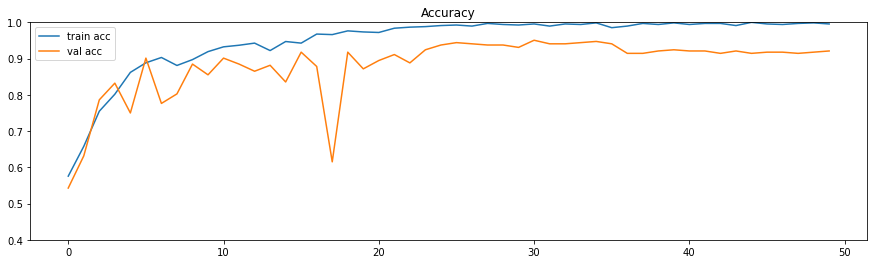

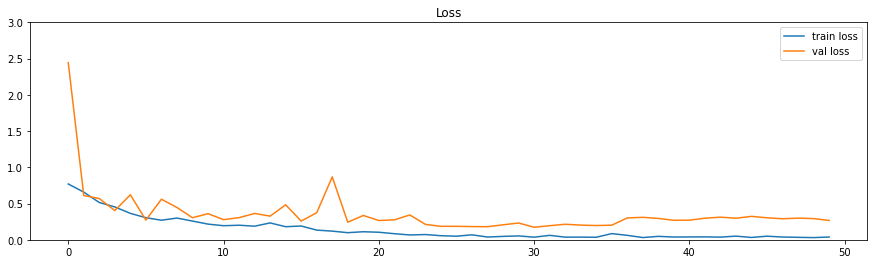

In [343]:
plt.figure(figsize=(15,4))
plt.plot(history.history["acc"],label="train acc")
plt.plot(history.history["val_acc"], label="val acc")
plt.ylim(0.4,1)
plt.title('Accuracy')
plt.legend()
plt.show()
plt.figure(figsize=(15,4))
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.ylim(0,3)
plt.title('Loss')
plt.legend()
plt.show()

In [15]:
def rescale(img):
    return np.add(np.multiply(img, 2/255), -1)

In [16]:
def classify_and_visualize(img_path):
    img = cv2.imread(img_path)
    detections = detector.detect_faces(img)
    faces = []
    boxes = []
    
    for det in detections:
        (x, y, w, h) = det['box']
        boxes.append(det['box'])
        cropped_face = img[y:y+h, x:x+w]
        cropped_face = cv2.resize(cropped_face, (128,128))
        cropped_face = rescale(cropped_face)
        faces.append(cropped_face)
        
    faces = np.array(faces)
    predictions = np.squeeze(model.predict(faces), axis=-1)
    str_predictions = np.array(['adult' if x<0.5 else 'child' for x in predictions]) 

    img  = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img, dtype=np.uint8)
    plt.axis("off")
    plt.imshow(img)
    ax = plt.gca()
    linewidth=1
    color=[0, 0, 1]
    
    for box, str_pred, pred in zip(boxes, str_predictions, predictions):
        text = "{}: {:.2f}".format(str_pred, pred)
        x, y, w, h = box
        patch = plt.Rectangle(
            [x, y], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(x, y, text,
                bbox={"facecolor": color, "alpha": 0.4},
                clip_box=ax.clipbox,
                clip_on=True,
        )
    plt.show()
    return ax

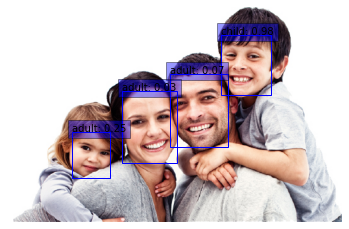

<AxesSubplot:>

In [19]:
classify_and_visualize('images/test/test8.png')

In [21]:
model.save('models/final_model.h5')